# Modelo 2 - Random Forest Diario

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from itertools import product

In [2]:
df = pd.read_csv('../data/handled/dataset_diario.csv')

In [5]:
df['ventana'] = pd.to_datetime(df['ventana'])

# Día de la semana (0 = lunes, 6 = domingo)
df['dia_semana'] = df['ventana'].dt.dayofweek
# Mes del año (1 a 12)
df['mes'] = df['ventana'].dt.month
# Día del mes (1 a 31)
df['semana_anio'] = df['ventana'].dt.isocalendar().week

In [9]:
print(df.columns)

Index(['ventana', 'id_estacion', 'bicis_arriban', 'partidas', 'partidas_lag_1',
       'partidas_lag_2', 'partidas_lag_3', 'cant_female', 'cant_male',
       'cant_other', 'latitud', 'longitud', 'cant_fit', 'cant_iconic',
       'es_finde', 'tipo_estacion', 'distancia_central_1',
       'distancia_central_2', 'distancia_central_3', 'distancia_central_4',
       'distancia_central_5', 'dia_semana', 'mes', 'semana_anio'],
      dtype='object')


In [21]:
features = ['id_estacion', 'partidas_lag_1',
       'partidas_lag_2', 'partidas_lag_3', 'latitud', 'longitud',
       'es_finde', 'tipo_estacion', 'distancia_central_1',
       'distancia_central_2', 'distancia_central_3', 'distancia_central_4',
       'distancia_central_5', 'dia_semana', 'mes', 'semana_anio']

X = df[features]
y = df['bicis_arriban']

In [22]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

print(f"Train set size: {y_train.shape[0]}")
print(f"Validation set size: {y_val.shape[0]}")
print(f"Test set size: {y_test.shape[0]}")

Train set size: 222552
Validation set size: 55639
Test set size: 69548
Train set size: 222552
Validation set size: 55639
Test set size: 69548


In [23]:
mapas_ordinales = {
    'tipo_estacion': {
        'fantasma': 0,
        'moderada': 1,
        'central': 2
    }
}

X_train['tipo_estacion'] = X_train['tipo_estacion'].map(mapas_ordinales['tipo_estacion'])
X_val['tipo_estacion'] = X_val['tipo_estacion'].map(mapas_ordinales['tipo_estacion'])


In [24]:
# Entrenar modelo (sin escalar)
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

# Predecir
y_pred_rf = rf.predict(X_val)

# Convertir a Series con mismo índice que y_val
y_pred_rf_series = pd.Series(y_pred_rf, index=y_val.index)

# Redondear (opcional)
y_pred_rf_rounded = y_pred_rf_series.round().astype(int)


In [25]:
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf_rounded))
mae_rf = mean_absolute_error(y_val, y_pred_rf_rounded)
r2_rf = r2_score(y_val, y_pred_rf_rounded)

print(f"Random Forest - RMSE: {rmse_rf:.2f}")
print(f"Random Forest - MAE: {mae_rf:.2f}")
print(f"Random Forest - R²: {r2_rf:.2f}")

Random Forest - RMSE: 12.91
Random Forest - MAE: 8.27
Random Forest - R²: 0.70


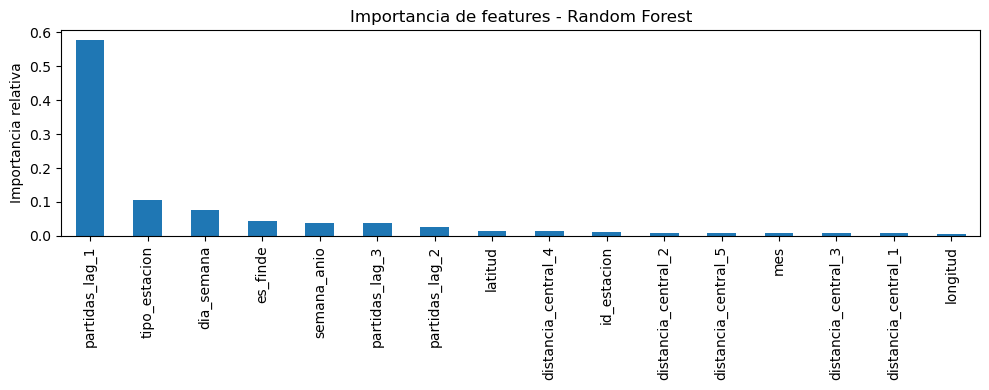

In [26]:
importancia = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,4))
importancia.plot(kind='bar')
plt.title("Importancia de features - Random Forest")
plt.ylabel("Importancia relativa")
plt.tight_layout()
plt.show()

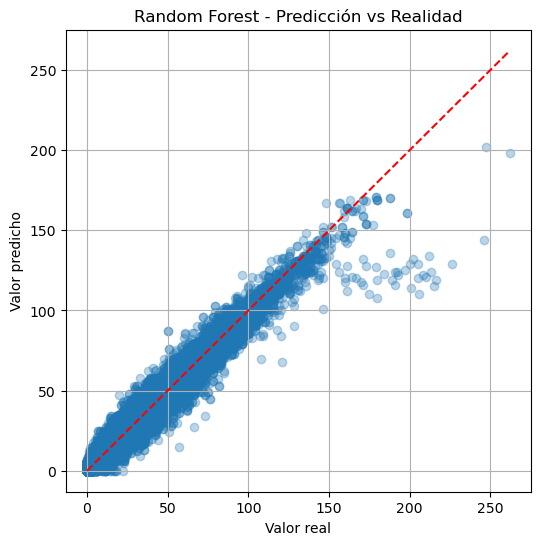

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_rf_rounded, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.title('Random Forest - Predicción vs Realidad')
plt.grid(True)
plt.show()

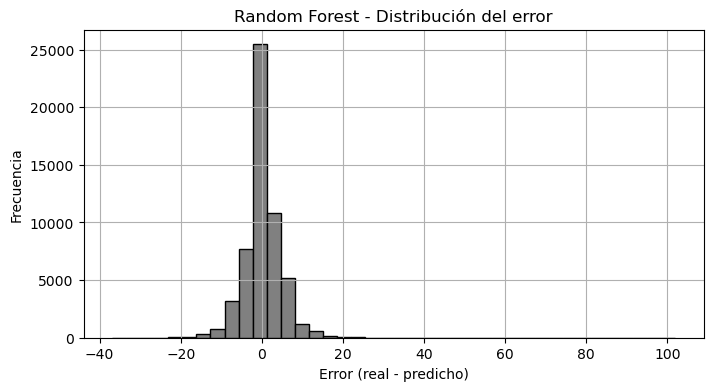

In [17]:
errores_rf = y_val - y_pred_rf_rounded

plt.figure(figsize=(8,4))
plt.hist(errores_rf, bins=40, color='gray', edgecolor='black')
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.title("Random Forest - Distribución del error")
plt.grid(True)
plt.show()


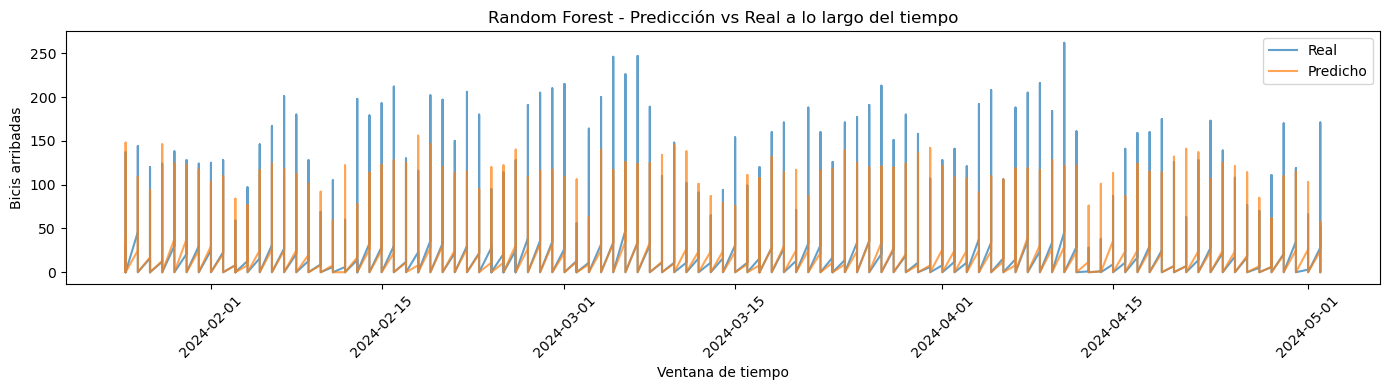

In [27]:
plt.figure(figsize=(14,4))
plt.plot(df.loc[y_val.index, 'ventana'], y_val, label='Real', alpha=0.7)
plt.plot(df.loc[y_val.index, 'ventana'], y_pred_rf_rounded, label='Predicho', alpha=0.7)
plt.xlabel("Ventana de tiempo")
plt.ylabel("Bicis arribadas")
plt.title("Random Forest - Predicción vs Real a lo largo del tiempo")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

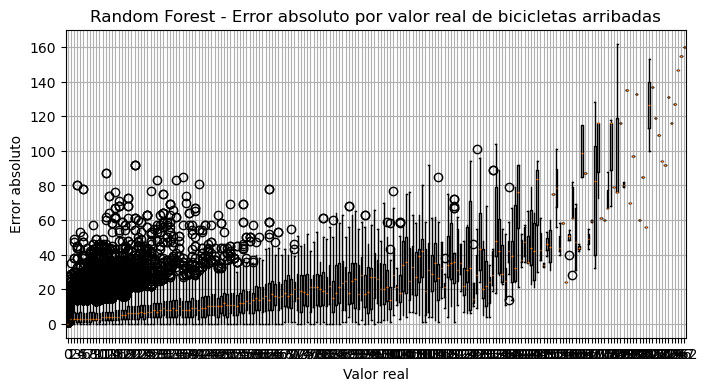

In [28]:
df_eval_rf = pd.DataFrame({
    'real': y_val,
    'pred': y_pred_rf_rounded
})
df_eval_rf['error'] = df_eval_rf['real'] - df_eval_rf['pred']
df_eval_rf['abs_error'] = df_eval_rf['error'].abs()

plt.figure(figsize=(8,4))
plt.boxplot(
    [df_eval_rf[df_eval_rf['real'] == v]['abs_error'] for v in sorted(df_eval_rf['real'].unique())],
    labels=sorted(df_eval_rf['real'].unique())
)
plt.title("Random Forest - Error absoluto por valor real de bicicletas arribadas")
plt.xlabel("Valor real")
plt.ylabel("Error absoluto")
plt.grid(True)
plt.show()


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from itertools import product
import numpy as np
import pandas as pd
import json

In [31]:
# Definí tu grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Generar todas las combinaciones posibles
param_combos = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features'],
    param_grid['bootstrap']
))

resultados = []

# Loop manual sobre cada combinación
for n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, bootstrap in param_combos:
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    resultado = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    resultados.append(resultado)

    with open("resultados_grid.json", "a") as f:
        json.dump(resultado, f)
        f.write("\n")


# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar las 5 mejores combinaciones según R²
top5 = df_resultados.sort_values(by='R2', ascending=False).head(5)
print(top5)


   n_estimators  max_depth  min_samples_split  min_samples_leaf max_features  \
6           200         20                  5                 2         sqrt   
2           100         20                  5                 2         sqrt   
7           200         20                  5                 2         sqrt   
3           100         20                  5                 2         sqrt   
1           100         10                  5                 2         sqrt   

        RMSE       MAE        R2  
6  12.137904  7.861050  0.734660  
2  12.145389  7.862551  0.734333  
7  12.228663  7.916766  0.730677  
3  12.234298  7.920505  0.730429  
1  12.270229  7.947682  0.728843  


In [32]:
# Entrenar modelo (sin escalar)
rf_2 = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, min_samples_leaf=2, max_features='sqrt', min_samples_split=5)
rf_2.fit(X_train, y_train)

# Predecir
y_pred_rf_2 = rf_2.predict(X_val)

# Convertir a Series con mismo índice que y_val
y_pred_rf_series_2 = pd.Series(y_pred_rf_2, index=y_val.index)

# Redondear (opcional)
y_pred_rf_rounded_2 = y_pred_rf_series_2.round().astype(int)


In [33]:
rmse_rf_2 = np.sqrt(mean_squared_error(y_val, y_pred_rf_rounded_2))
mae_rf_2 = mean_absolute_error(y_val, y_pred_rf_rounded_2)
r2_rf_2 = r2_score(y_val, y_pred_rf_rounded_2)

print(f"Random Forest - RMSE: {rmse_rf_2:.2f}")
print(f"Random Forest - MAE: {mae_rf_2:.2f}")
print(f"Random Forest - R²: {r2_rf_2:.2f}")

Random Forest - RMSE: 12.14
Random Forest - MAE: 7.85
Random Forest - R²: 0.73
